In [ ]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 36.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=c648b4aca400fc09474c27cc464d2a93a7acac2a2634d884f84aec24bf653c95
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data

from shutil import copyfile
import torch.nn.functional as F
from torch_geometric.nn import GATConv

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/drive/MyDrive'
%cd 'CS 7643 Project/'
%cd 'ST_GAT'

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/CS 7643 Project
/content/drive/MyDrive/CS 7643 Project/ST_GAT


In [ ]:
class CustomDataset(InMemoryDataset):
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_sensor, self.mean, self.std_dev = torch.load(self.processed_paths[0])
    @property
    def processed_file_names(self):
        return ['./data.pt']

In [ ]:
class ST_GAT(torch.nn.Module):

    def __init__(self, in_channels, out_channels, n_sensors, heads=8, dropout=0.1):
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_sensors = n_sensors
        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        self.gat = GATConv(in_channels=in_channels, out_channels = in_channels, heads = heads, dropout = 0, concat = False)

        self.lstm1 = torch.nn.LSTM(input_size=self.n_sensors, hidden_size = lstm1_hidden_size, num_layers = 1)
        for name, par in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(par, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(par)

        self.lstm2 = torch.nn.LSTM(input_size = lstm1_hidden_size, hidden_size = lstm2_hidden_size, num_layers = 1)
        for name, par in self.lstm2.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(par, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(par)

        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_sensors * self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        x, edge_ind = data.x, data.edge_index

        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)
        
        # GAT
        x = self.gat(x, edge_ind)
        x = F.dropout(x, self.dropout, training=self.training)

        # LSTM
        batch = data.num_graphs
        n_sensor = int(data.num_nodes / batch)
        x = torch.reshape(x, (batch, n_sensor, data.num_features))
        x = torch.movedim(x, 2, 0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = torch.squeeze(x[-1,:,:])

        x = self.linear(x)

        shape = x.shape
        x = torch.reshape(x, (shape[0], self.n_sensors, self.n_pred))

        x = torch.reshape(x, (shape[0] * self.n_sensors, self.n_pred))
        return x


In [ ]:
def make_model(config):
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_sensors=config['N_SENSOR'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_func = torch.nn.MSELoss
    return model, optimizer, loss_func

In [ ]:
## Utils
def normalize(x, mean, std):
    return (x-mean) / std

def undo_normalize(x_norm, mean, std):
    val = x_norm * std + mean
    return val

def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    # Attention adjacency matrix
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

def split_data(dataset, n_slot, splits):
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test

In [ ]:
def train(model, device, train_dataloader, val_dataloader, optimizer, loss_func, config):
    for epoch in range(config['EPOCHS']):
        print('training')
        model.train()
        for _, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
            batch = batch.to(device)
            optimizer.zero_grad()
            y_pred = torch.squeeze(model(batch, device))
            loss = loss_func()(y_pred.float(), torch.squeeze(batch.y).float())
            loss.backward()
            optimizer.step()
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
    return model

@torch.no_grad()
def eval(model, device, dataloader, type=''):
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = undo_normalize(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = undo_normalize(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            
            y_truth[i ,:pred.shape[0], :] = truth
            y_pred[i, :pred.shape[0], :] = pred
            if device == 'cpu':
                truth = truth.numpy()
                pred = pred.numpy()
            else:
                truth = truth.cpu().numpy()
                pred = pred.cpu().numpy()
            rmse += mean_squared_error(truth, pred, squared=False)
            mae += mean_absolute_error(truth, pred)
            mape += mean_absolute_percentage_error(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    return rmse, mae, mape, y_pred, y_truth

def test(model, test_dataloader, device, config):
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
    plot_prediction(test_dataloader, y_pred, y_truth, 0, config)


In [ ]:
# set hyperparameters according to original paper + dataset specific params
config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 100,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 119,
    # number of sensors in data
    'N_SENSOR': 207,
    'DATASET': 'METR-LA'
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1
if config['DATASET'] == 'METR-LA':
    distance_path = '../Datasets/METR-LA-Mar 1st to Jun 30th 2012(119 days)-207 Sensors/Distance_Matrix.csv'
else:
    distance_path = '../Datasets/PeMS-May 1st to June 30th 2012(44 days)-228 Sensors/Distance_Matrix.csv'
# Load the weight dataset
distances = pd.read_csv(distance_path, header=None).values
W = distance_to_weight(distances, gat_version=True)
dataset = CustomDataset(config, W)
#dataset.process()


In [ ]:
# total of 119 days in the dataset, use 83 for training, 18 for val, 18 for test(70%,15%,15% data split))
d_train, d_val, d_test = split_data(dataset, config['N_SLOT'], (83, 18, 18))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)
model, optimizer, loss_fn = make_model(config)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
model = model.to(device)
#Train model
config['N_SENSOR'] = dataset.n_sensor
model = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, config=config, device=device, loss_func=loss_fn, model=model, optimizer=optimizer)

Using cuda
training


Epoch 0: 100%|██████████| 445/445 [00:13<00:00, 33.00it/s]


Train, MAE: 7.99249647869153, RMSE: 13.300959985711602, MAPE: 6420574169158506.0
Valid, MAE: 8.30636497871163, RMSE: 13.968556295965136, MAPE: 7559332681444405.0
training


Epoch 1: 100%|██████████| 445/445 [00:11<00:00, 38.51it/s]


training


Epoch 2: 100%|██████████| 445/445 [00:11<00:00, 38.45it/s]


training


Epoch 3: 100%|██████████| 445/445 [00:11<00:00, 38.49it/s]


training


Epoch 4: 100%|██████████| 445/445 [00:11<00:00, 38.56it/s]


training


Epoch 5: 100%|██████████| 445/445 [00:11<00:00, 38.50it/s]


Train, MAE: 6.580981730343251, RMSE: 11.89377414189028, MAPE: 6572549094398693.0
Valid, MAE: 6.879245851457734, RMSE: 12.6916582363168, MAPE: 7825789115032988.0
training


Epoch 6: 100%|██████████| 445/445 [00:11<00:00, 38.66it/s]


training


Epoch 7: 100%|██████████| 445/445 [00:11<00:00, 38.65it/s]


training


Epoch 8: 100%|██████████| 445/445 [00:11<00:00, 38.59it/s]


training


Epoch 9: 100%|██████████| 445/445 [00:11<00:00, 38.65it/s]


training


Epoch 10: 100%|██████████| 445/445 [00:11<00:00, 38.84it/s]


Train, MAE: 6.15841529931915, RMSE: 10.984147254000888, MAPE: 5968865288093770.0
Valid, MAE: 6.882664660817569, RMSE: 12.401363923377598, MAPE: 8063549261504259.0
training


Epoch 11: 100%|██████████| 445/445 [00:11<00:00, 38.84it/s]


training


Epoch 12: 100%|██████████| 445/445 [00:11<00:00, 38.89it/s]


training


Epoch 13: 100%|██████████| 445/445 [00:11<00:00, 39.05it/s]


training


Epoch 14: 100%|██████████| 445/445 [00:11<00:00, 39.03it/s]


training


Epoch 15: 100%|██████████| 445/445 [00:11<00:00, 38.87it/s]


Train, MAE: 5.589686570542582, RMSE: 10.467741689789161, MAPE: 5106927455083347.0
Valid, MAE: 6.441227023134527, RMSE: 12.245531239460425, MAPE: 7601465903813917.0
training


Epoch 16: 100%|██████████| 445/445 [00:11<00:00, 39.14it/s]


training


Epoch 17: 100%|██████████| 445/445 [00:11<00:00, 39.41it/s]


training


Epoch 18: 100%|██████████| 445/445 [00:11<00:00, 39.23it/s]


training


Epoch 19: 100%|██████████| 445/445 [00:11<00:00, 39.17it/s]


training


Epoch 20: 100%|██████████| 445/445 [00:11<00:00, 39.09it/s]


Train, MAE: 5.659486718124218, RMSE: 10.048178355613452, MAPE: 4830821274960424.0
Valid, MAE: 6.667683335923657, RMSE: 12.036669642654891, MAPE: 7427246198131005.0
training


Epoch 21: 100%|██████████| 445/445 [00:11<00:00, 39.43it/s]


training


Epoch 22: 100%|██████████| 445/445 [00:11<00:00, 39.44it/s]


training


Epoch 23: 100%|██████████| 445/445 [00:11<00:00, 39.41it/s]


training


Epoch 24: 100%|██████████| 445/445 [00:11<00:00, 39.72it/s]


training


Epoch 25: 100%|██████████| 445/445 [00:11<00:00, 39.50it/s]


Train, MAE: 5.426159047544672, RMSE: 9.715411771281381, MAPE: 4719174100778272.0
Valid, MAE: 6.462681735913778, RMSE: 11.712907810801083, MAPE: 7542818410426748.0
training


Epoch 26: 100%|██████████| 445/445 [00:11<00:00, 39.45it/s]


training


Epoch 27: 100%|██████████| 445/445 [00:11<00:00, 39.50it/s]


training


Epoch 28: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 29: 100%|██████████| 445/445 [00:11<00:00, 39.67it/s]


training


Epoch 30: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


Train, MAE: 5.223957789346073, RMSE: 9.451207930318425, MAPE: 4411140344149339.5
Valid, MAE: 6.238629640992155, RMSE: 11.50175933247989, MAPE: 7271305117766265.0
training


Epoch 31: 100%|██████████| 445/445 [00:11<00:00, 39.54it/s]


training


Epoch 32: 100%|██████████| 445/445 [00:11<00:00, 39.53it/s]


training


Epoch 33: 100%|██████████| 445/445 [00:11<00:00, 39.57it/s]


training


Epoch 34: 100%|██████████| 445/445 [00:11<00:00, 39.58it/s]


training


Epoch 35: 100%|██████████| 445/445 [00:11<00:00, 39.47it/s]


Train, MAE: 5.115576622459326, RMSE: 9.302999764346005, MAPE: 4357614995264804.0
Valid, MAE: 6.22988778045497, RMSE: 11.437317799047097, MAPE: 7190006642099696.0
training


Epoch 36: 100%|██████████| 445/445 [00:11<00:00, 39.55it/s]


training


Epoch 37: 100%|██████████| 445/445 [00:11<00:00, 39.60it/s]


training


Epoch 38: 100%|██████████| 445/445 [00:11<00:00, 39.47it/s]


training


Epoch 39: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 40: 100%|██████████| 445/445 [00:11<00:00, 39.53it/s]


Train, MAE: 5.094600324952201, RMSE: 9.081304144055656, MAPE: 4131769131999287.0
Valid, MAE: 6.512910636429934, RMSE: 11.61895403911158, MAPE: 7123755598191542.0
training


Epoch 41: 100%|██████████| 445/445 [00:11<00:00, 39.54it/s]


training


Epoch 42: 100%|██████████| 445/445 [00:11<00:00, 39.50it/s]


training


Epoch 43: 100%|██████████| 445/445 [00:11<00:00, 39.52it/s]


training


Epoch 44: 100%|██████████| 445/445 [00:11<00:00, 39.55it/s]


training


Epoch 45: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


Train, MAE: 5.06886176473639, RMSE: 8.958788565303502, MAPE: 3736004470808263.0
Valid, MAE: 6.66315231618193, RMSE: 11.815206508046574, MAPE: 6839164727867920.0
training


Epoch 46: 100%|██████████| 445/445 [00:11<00:00, 39.53it/s]


training


Epoch 47: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 48: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 49: 100%|██████████| 445/445 [00:11<00:00, 39.55it/s]


training


Epoch 50: 100%|██████████| 445/445 [00:11<00:00, 39.48it/s]


Train, MAE: 4.896972010108862, RMSE: 8.824800586700439, MAPE: 4045847954133167.0
Valid, MAE: 6.1523125687825315, RMSE: 11.400328606674352, MAPE: 7371981788493676.0
training


Epoch 51: 100%|██████████| 445/445 [00:11<00:00, 39.57it/s]


training


Epoch 52: 100%|██████████| 445/445 [00:11<00:00, 39.55it/s]


training


Epoch 53: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 54: 100%|██████████| 445/445 [00:11<00:00, 39.54it/s]


training


Epoch 55: 100%|██████████| 445/445 [00:11<00:00, 39.57it/s]


Train, MAE: 4.798499283629857, RMSE: 8.669350899471326, MAPE: 3474276474282812.5
Valid, MAE: 6.128670938236198, RMSE: 11.461686576764608, MAPE: 6666651275429867.0
training


Epoch 56: 100%|██████████| 445/445 [00:11<00:00, 39.59it/s]


training


Epoch 57: 100%|██████████| 445/445 [00:11<00:00, 39.58it/s]


training


Epoch 58: 100%|██████████| 445/445 [00:11<00:00, 39.63it/s]


training


Epoch 59: 100%|██████████| 445/445 [00:11<00:00, 39.59it/s]


training


Epoch 60: 100%|██████████| 445/445 [00:11<00:00, 39.67it/s]


Train, MAE: 4.761033137996545, RMSE: 8.624803783116716, MAPE: 3544853144643726.5
Valid, MAE: 6.129819506222439, RMSE: 11.456117059766632, MAPE: 6758195625273238.0
training


Epoch 61: 100%|██████████| 445/445 [00:11<00:00, 39.59it/s]


training


Epoch 62: 100%|██████████| 445/445 [00:11<00:00, 39.64it/s]


training


Epoch 63: 100%|██████████| 445/445 [00:11<00:00, 39.60it/s]


training


Epoch 64: 100%|██████████| 445/445 [00:11<00:00, 39.69it/s]


training


Epoch 65: 100%|██████████| 445/445 [00:11<00:00, 39.63it/s]


Train, MAE: 4.859338676795531, RMSE: 8.551935813132296, MAPE: 3758139844001939.5
Valid, MAE: 6.2337219739697645, RMSE: 11.381434145661974, MAPE: 7220301124737636.0
training


Epoch 66: 100%|██████████| 445/445 [00:11<00:00, 39.59it/s]


training


Epoch 67: 100%|██████████| 445/445 [00:11<00:00, 39.72it/s]


training


Epoch 68: 100%|██████████| 445/445 [00:11<00:00, 39.61it/s]


training


Epoch 69: 100%|██████████| 445/445 [00:11<00:00, 39.61it/s]


training


Epoch 70: 100%|██████████| 445/445 [00:11<00:00, 39.75it/s]


Train, MAE: 4.705324430144235, RMSE: 8.492020572705215, MAPE: 3356431436082878.0
Valid, MAE: 6.085277744175232, RMSE: 11.377733112610493, MAPE: 6759252112508907.0
training


Epoch 71: 100%|██████████| 445/445 [00:11<00:00, 39.61it/s]


training


Epoch 72: 100%|██████████| 445/445 [00:11<00:00, 39.53it/s]


training


Epoch 73: 100%|██████████| 445/445 [00:11<00:00, 39.35it/s]


training


Epoch 74: 100%|██████████| 445/445 [00:11<00:00, 39.56it/s]


training


Epoch 75: 100%|██████████| 445/445 [00:11<00:00, 39.66it/s]


Train, MAE: 4.647624644268765, RMSE: 8.428295148356577, MAPE: 3159440173213397.0
Valid, MAE: 6.0484092456778304, RMSE: 11.341564424259147, MAPE: 6514564178254436.0
training


Epoch 76: 100%|██████████| 445/445 [00:11<00:00, 39.65it/s]


training


Epoch 77: 100%|██████████| 445/445 [00:11<00:00, 39.72it/s]


training


Epoch 78: 100%|██████████| 445/445 [00:11<00:00, 39.72it/s]


training


Epoch 79: 100%|██████████| 445/445 [00:11<00:00, 39.74it/s]


training


Epoch 80: 100%|██████████| 445/445 [00:11<00:00, 39.78it/s]


Train, MAE: 4.719565739256613, RMSE: 8.430457720595799, MAPE: 3827430434814932.5
Valid, MAE: 6.164618025121, RMSE: 11.455596815679492, MAPE: 7534029570696604.0
training


Epoch 81: 100%|██████████| 445/445 [00:11<00:00, 39.77it/s]


training


Epoch 82: 100%|██████████| 445/445 [00:11<00:00, 39.71it/s]


training


Epoch 83: 100%|██████████| 445/445 [00:11<00:00, 39.15it/s]


training


Epoch 84: 100%|██████████| 445/445 [00:11<00:00, 39.75it/s]


training


Epoch 85: 100%|██████████| 445/445 [00:11<00:00, 39.67it/s]


Train, MAE: 4.664551958877049, RMSE: 8.400673645533873, MAPE: 3226924129314774.5
Valid, MAE: 6.179903900500426, RMSE: 11.54977855977324, MAPE: 6875959361236021.0
training


Epoch 86: 100%|██████████| 445/445 [00:11<00:00, 39.70it/s]


training


Epoch 87: 100%|██████████| 445/445 [00:11<00:00, 39.76it/s]


training


Epoch 88: 100%|██████████| 445/445 [00:11<00:00, 39.76it/s]


training


Epoch 89: 100%|██████████| 445/445 [00:11<00:00, 39.46it/s]


training


Epoch 90: 100%|██████████| 445/445 [00:11<00:00, 39.60it/s]


Train, MAE: 4.671664250298832, RMSE: 8.327480402957187, MAPE: 3015500222722830.5
Valid, MAE: 6.147932839147823, RMSE: 11.349530632962885, MAPE: 6411796359348900.0
training


Epoch 91: 100%|██████████| 445/445 [00:11<00:00, 39.69it/s]


training


Epoch 92: 100%|██████████| 445/445 [00:11<00:00, 39.55it/s]


training


Epoch 93: 100%|██████████| 445/445 [00:11<00:00, 39.53it/s]


training


Epoch 94: 100%|██████████| 445/445 [00:11<00:00, 39.54it/s]


training


Epoch 95: 100%|██████████| 445/445 [00:11<00:00, 39.60it/s]


Train, MAE: 4.609684486603469, RMSE: 8.274073518260142, MAPE: 3287102856073022.5
Valid, MAE: 6.082167237075334, RMSE: 11.346020364269767, MAPE: 6827283459104515.0
training


Epoch 96: 100%|██████████| 445/445 [00:11<00:00, 39.40it/s]


training


Epoch 97: 100%|██████████| 445/445 [00:11<00:00, 39.52it/s]


training


Epoch 98: 100%|██████████| 445/445 [00:11<00:00, 39.35it/s]


training


Epoch 99: 100%|██████████| 445/445 [00:11<00:00, 39.42it/s]


In [ ]:
def plot_prediction(pred, label, node, config):
    s = label.shape
    label = label.reshape(s[0], config['BATCH_SIZE'], config['N_SENSOR'], s[-1])
    label = label[:, :, node, 0]
    label = torch.flatten(label)
    day0_label = label[:config['N_SLOT']]

    s = pred.shape
    pred = pred.reshape(s[0], config['BATCH_SIZE'], config['N_SENSOR'], s[-1])
    pred = pred[:, :, node, 0]
    pred = torch.flatten(pred)
    day0_pred = pred[:config['N_SLOT']]
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.figure()
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_label, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed Prediction')
    plt.title('Traffic Prediction Over Time')
    plt.legend()
    plt.savefig('predictions.png')
    plt.show()

In [ ]:
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')

Test, MAE: 6.909642858603566, RMSE: 12.043438137192087, MAPE: 8248589314341054.0


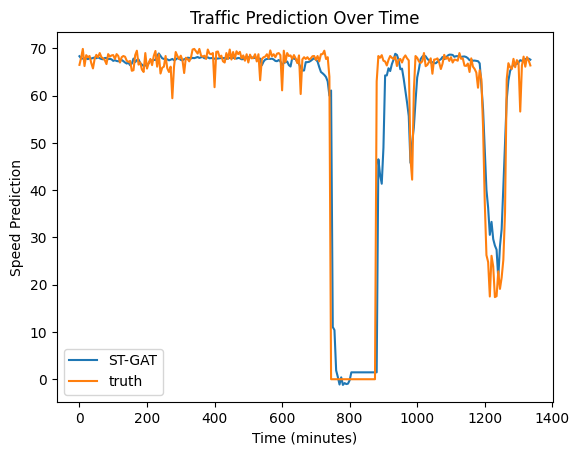

In [ ]:
plot_prediction(y_pred, y_truth, 159, config)